In [ ]:
# ids_gan_atso.py
# Full pipeline: load IDS-ready CSV, train GAN for augmentation, then classifier with ATSO-like teacher-student + adaptive LR.
# Requires: torch, sklearn, pandas, numpy, tqdm, matplotlib (optional)
# Usage: python ids_gan_atso.py

import os
import math
import random
import numpy as np
import pandas as pd
from datetime import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.optim import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from tqdm import tqdm

# --------------------------
# Config / Hyperparameters
# --------------------------
DATA_PATH = "/content/iot_telemetry_ids_ready.csv"   # your generated file
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# GAN params
GAN_EPOCHS = 100
G_BATCH_SIZE = 256
LATENT_DIM = 16
GAN_LR = 2e-4
CRITIC_ITERS = 5  # WGAN-GP style
GRAD_PENALTY_WEIGHT = 10.0

# Classifier / ATSO params
CLASS_BATCH_SIZE = 256
CLASS_EPOCHS = 60
CLASS_LR = 1e-3
WEIGHT_DECAY = 1e-5
EMA_DECAY = 0.999  # teacher smoothing
UNLABELED_FRACTION = 0.8  # fraction of train considered "unlabeled" for ATSO pseudo-labeling
LABELED_FRACTION = 0.2    # fraction labeled (simulated)
PSEUDO_LABEL_CONFIDENCE = 0.9  # threshold for using pseudo labels
AUGMENT_SYNTHETIC = True     # whether to augment classifier trainset with GAN-samples

MODEL_DIR = "./models_ids"
os.makedirs(MODEL_DIR, exist_ok=True)
SEED = 42

# --------------------------
# Utilities / Seeds
# --------------------------
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(SEED)

# --------------------------
# Load & preprocess dataset
# --------------------------
df = pd.read_csv(DATA_PATH)

# Expected columns: temp, humidity, device_id, timestamp, label, attack_type
# Keep only required columns; if names mismatch, adjust.
required_cols = ['temp', 'humidity', 'device_id', 'timestamp', 'label', 'attack_type']
for c in required_cols:
    if c not in df.columns:
        raise ValueError(f"Expected column '{c}' in {DATA_PATH} but not found.")

# Feature engineering: numeric features + device one-hot + cyclical time features (hour, minute)
def preprocess_df(df):
    df2 = df.copy()
    # Ensure timestamp is datetime
    df2['timestamp'] = pd.to_datetime(df2['timestamp'])
    df2['hour'] = df2['timestamp'].dt.hour
    df2['minute'] = df2['timestamp'].dt.minute
    # cyclical transform for hour/minute
    df2['hour_sin'] = np.sin(2 * np.pi * df2['hour'] / 24.0)
    df2['hour_cos'] = np.cos(2 * np.pi * df2['hour'] / 24.0)
    df2['minute_sin'] = np.sin(2 * np.pi * df2['minute'] / 60.0)
    df2['minute_cos'] = np.cos(2 * np.pi * df2['minute'] / 60.0)

    # Device one-hot
    device_ohe = pd.get_dummies(df2['device_id'], prefix='dev')
    df2 = pd.concat([df2, device_ohe], axis=1)

    # numeric features selection
    features = ['temp', 'humidity', 'hour_sin', 'hour_cos', 'minute_sin', 'minute_cos'] + list(device_ohe.columns)
    X = df2[features].astype(float).values
    y = df2['label'].astype(int).values
    return X, y, features

X, y, feature_names = preprocess_df(df)
print(f"Features: {feature_names}")
print("Data shape:", X.shape, y.sum(), "attacks out of", len(y))

# Standardize numeric features (only temp/humidity/hour/minute cyclical)
scaler = StandardScaler()
X[:, :6] = scaler.fit_transform(X[:, :6])  # first 6 are numeric/cyclical

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=SEED)

# For ATSO simulation: we will treat a fraction of training data as labeled
idx = np.arange(len(X_train))
train_l_idx, train_u_idx = train_test_split(idx, test_size=UNLABELED_FRACTION, stratify=y_train, random_state=SEED)
# train_l_idx: labeled subset, train_u_idx: unlabeled subset (we still have labels but will simulate unlabeled)

print("Train total:", len(X_train), "Labeled subset:", len(train_l_idx), "Unlabeled subset:", len(train_u_idx))

# --------------------------
# PyTorch Dataset wrappers
# --------------------------
class TabularDataset(Dataset):
    def __init__(self, X, y=None):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = None if y is None else torch.tensor(y, dtype=torch.long)

    def __len__(self): return len(self.X)
    def __getitem__(self, i):
        if self.y is None:
            return self.X[i]
        return self.X[i], self.y[i]

train_l_ds = TabularDataset(X_train[train_l_idx], y_train[train_l_idx])
train_u_ds = TabularDataset(X_train[train_u_idx])  # unlabeled (we keep labels separately for eval)
train_full_ds = TabularDataset(X_train, y_train)
test_ds = TabularDataset(X_test, y_test)

train_l_dl = DataLoader(train_l_ds, batch_size=CLASS_BATCH_SIZE, shuffle=True, drop_last=True)
train_u_dl = DataLoader(train_u_ds, batch_size=CLASS_BATCH_SIZE, shuffle=True, drop_last=True)
train_full_dl = DataLoader(train_full_ds, batch_size=CLASS_BATCH_SIZE, shuffle=True, drop_last=False)
test_dl = DataLoader(test_ds, batch_size=CLASS_BATCH_SIZE, shuffle=False)

# Also create index-based access for unlabeled pseudo-label updates
X_train_u = X_train[train_u_idx]
y_train_u = y_train[train_u_idx]

# --------------------------
# GAN: generator and critic (WGAN-GP style) for tabular data
# --------------------------
DIMS = X.shape[1]

def weights_init(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

class Generator(nn.Module):
    def __init__(self, latent_dim, out_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, out_dim)
        )
    def forward(self, z):
        return self.net(z)

class Critic(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1)
        )
    def forward(self, x):
        return self.net(x).view(-1)

# Instantiate GAN
G = Generator(LATENT_DIM, DIMS).to(DEVICE)
D = Critic(DIMS).to(DEVICE)
G.apply(weights_init)
D.apply(weights_init)

opt_G = Adam(G.parameters(), lr=GAN_LR, betas=(0.5, 0.9))
opt_D = Adam(D.parameters(), lr=GAN_LR, betas=(0.5, 0.9))

# We'll train GAN on the attack samples only (so it can generate attack samples to augment)
X_attacks = X_train[y_train == 1]
attack_ds = TabularDataset(X_attacks)
attack_dl = DataLoader(attack_ds, batch_size=G_BATCH_SIZE, shuffle=True, drop_last=True)

def gradient_penalty(critic, real_data, fake_data):
    alpha = torch.rand(real_data.size(0), 1).to(DEVICE)
    alpha = alpha.expand_as(real_data)
    interpolates = alpha * real_data + (1 - alpha) * fake_data
    interpolates.requires_grad_(True)
    d_interpolates = critic(interpolates)
    grads = torch.autograd.grad(outputs=d_interpolates, inputs=interpolates,
                                grad_outputs=torch.ones_like(d_interpolates).to(DEVICE),
                                create_graph=True, retain_graph=True, only_inputs=True)[0]
    grads = grads.view(grads.size(0), -1)
    grad_norm = torch.sqrt(torch.sum(grads ** 2, dim=1) + 1e-12)
    gp = ((grad_norm - 1.0) ** 2).mean()
    return gp

print("Starting GAN training on attack subset...")
for epoch in range(GAN_EPOCHS):
    d_losses = []
    g_losses = []
    for real in attack_dl:
        real = real.to(DEVICE)
        # Train critic
        for _ in range(CRITIC_ITERS):
            z = torch.randn(real.size(0), LATENT_DIM).to(DEVICE)
            fake = G(z).detach()
            d_real = D(real)
            d_fake = D(fake)
            gp = gradient_penalty(D, real, fake)
            d_loss = d_fake.mean() - d_real.mean() + GRAD_PENALTY_WEIGHT * gp
            opt_D.zero_grad()
            d_loss.backward()
            opt_D.step()

        # Train generator
        z = torch.randn(real.size(0), LATENT_DIM).to(DEVICE)
        fake = G(z)
        g_loss = -D(fake).mean()
        opt_G.zero_grad()
        g_loss.backward()
        opt_G.step()

        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())

    if (epoch + 1) % 20 == 0 or epoch == 0:
        print(f"GAN Epoch {epoch+1}/{GAN_EPOCHS}  D_loss={np.mean(d_losses):.4f}  G_loss={np.mean(g_losses):.4f}")

print("GAN training finished.")

# Function to sample synthetic attack examples
def sample_gan_attacks(n):
    G.eval()
    with torch.no_grad():
        z = torch.randn(n, LATENT_DIM).to(DEVICE)
        synth = G(z).cpu().numpy()
    return synth

# --------------------------
# Classifier: student + teacher (EMA)
# --------------------------
class Classifier(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 2)
        )
    def forward(self, x):
        return self.net(x)

student = Classifier(DIMS).to(DEVICE)
teacher = Classifier(DIMS).to(DEVICE)
teacher.load_state_dict(student.state_dict())  # initialize identical
for p in teacher.parameters():
    p.requires_grad = False

optimizer = Adam(student.parameters(), lr=CLASS_LR, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5, verbose=True)

criterion = nn.CrossEntropyLoss()

def update_ema(teacher, student, alpha):
    for t_param, s_param in zip(teacher.parameters(), student.parameters()):
        t_param.data.mul_(alpha).add_(s_param.data * (1.0 - alpha))

# ATSO-like routine: partition unlabeled train_u into A and B, alternate.
# We will use pseudo-labeling from teacher on one partition and fine-tune student on it,
# while using the other partition for label updates in the next cycle.

# Partition unlabeled set into two halves A and B
perm = np.random.permutation(len(X_train_u))
mid = len(perm) // 2
A_idx = perm[:mid]
B_idx = perm[mid:]

X_A = X_train_u[A_idx]
X_B = X_train_u[B_idx]
y_A_true = y_train_u[A_idx]  # we keep true labels for eval only
y_B_true = y_train_u[B_idx]

# Start ATSO-classifier training
best_val_auc = 0.0
history = []

# Optionally augment labeled set with GAN-sampled attacks to balance / enlarge data
def get_augmented_labeled_set(num_synth_per_class=1000):
    # Combine labeled real data with synthetic attack samples and synthetic normal (if desired)
    X_l = X_train[train_l_idx].copy()
    y_l = y_train[train_l_idx].copy()

    if AUGMENT_SYNTHETIC:
        # produce synthetic attacks
        n_synth = num_synth_per_class
        synth_att = sample_gan_attacks(n_synth)
        # invert scaling for first 6 features? no need; GAN produced standardized features (we trained on standardized)
        y_synth = np.ones(n_synth, dtype=int)
        X_l = np.vstack([X_l, synth_att])
        y_l = np.hstack([y_l, y_synth])

    return X_l, y_l

print("Starting classifier training with ATSO loop...")

for epoch in range(CLASS_EPOCHS):
    student.train()
    teacher.train()  # teacher is not updated by optimizer, but used to generate pseudo-labels

    # --- Phase 1: generate pseudo-labels on partition A using teacher, fine-tune student on A (student learns from pseudo labels)
    # teacher produces softmax probs; we accept high-confidence pseudo-labels
    with torch.no_grad():
        teacher.eval()
        X_A_t = torch.tensor(X_A, dtype=torch.float32).to(DEVICE)
        logits_A = teacher(X_A_t)
        probs_A = F.softmax(logits_A, dim=1).cpu().numpy()
        pseudo_labels_A = np.argmax(probs_A, axis=1)
        pseudo_conf_A = np.max(probs_A, axis=1)

    # mask high-confidence pseudo labels
    high_conf_mask_A = pseudo_conf_A >= PSEUDO_LABEL_CONFIDENCE
    use_idx_A = np.where(high_conf_mask_A)[0]

    # prepare training data for this phase
    if len(use_idx_A) > 0:
        X_phase_A = X_A[use_idx_A]
        y_phase_A = pseudo_labels_A[use_idx_A]
        ds_phase_A = TabularDataset(X_phase_A, y_phase_A)
        dl_phase_A = DataLoader(ds_phase_A, batch_size=CLASS_BATCH_SIZE, shuffle=True)
        # train student
        for xb, yb in dl_phase_A:
            xb = xb.to(DEVICE); yb = yb.to(DEVICE)
            optimizer.zero_grad()
            out = student(xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()
            # EMA update teacher
            update_ema(teacher, student, EMA_DECAY)

    # --- Phase 2: generate pseudo-labels on partition B using student (or teacher), fine-tune student on real labeled set + synthetic
    with torch.no_grad():
        student.eval()
        X_B_t = torch.tensor(X_B, dtype=torch.float32).to(DEVICE)
        logits_B = student(X_B_t)
        probs_B = F.softmax(logits_B, dim=1).cpu().numpy()
        pseudo_labels_B = np.argmax(probs_B, axis=1)
        pseudo_conf_B = np.max(probs_B, axis=1)
    high_conf_mask_B = pseudo_conf_B >= PSEUDO_LABEL_CONFIDENCE
    use_idx_B = np.where(high_conf_mask_B)[0]

    # Build labeled training set for second phase: original labeled set + high-conf pseudo-B + (optionally) GAN synth
    X_l_set, y_l_set = get_augmented_labeled_set(num_synth_per_class=512)
    if len(use_idx_B) > 0:
        X_l_set = np.vstack([X_l_set, X_B[use_idx_B]])
        y_l_set = np.hstack([y_l_set, pseudo_labels_B[use_idx_B]])

    # Train student for one epoch on X_l_set
    ds_l_mix = TabularDataset(X_l_set, y_l_set)
    dl_l_mix = DataLoader(ds_l_mix, batch_size=CLASS_BATCH_SIZE, shuffle=True)
    for xb, yb in dl_l_mix:
        xb = xb.to(DEVICE); yb = yb.to(DEVICE)
        optimizer.zero_grad()
        out = student(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        update_ema(teacher, student, EMA_DECAY)

    # Optionally swap partitions for next epoch (asynchronous alternation)
    X_A, X_B = X_B, X_A
    y_A_true, y_B_true = y_B_true, y_A_true

    # Validation on holdout test set
    student.eval()
    preds = []
    probs = []
    ys = []
    with torch.no_grad():
        for xb, yb in test_dl:
            xb = xb.to(DEVICE)
            out = student(xb)
            p = F.softmax(out, dim=1)[:,1].cpu().numpy()
            pred = np.argmax(out.cpu().numpy(), axis=1)
            preds.append(pred)
            probs.append(p)
            ys.append(yb.numpy())
    preds = np.concatenate(preds)
    probs = np.concatenate(probs)
    ys = np.concatenate(ys)

    acc = accuracy_score(ys, preds)
    prec = precision_score(ys, preds, zero_division=0)
    rec = recall_score(ys, preds, zero_division=0)
    f1 = f1_score(ys, preds, zero_division=0)
    try:
        auc = roc_auc_score(ys, probs)
    except:
        auc = 0.0
    cm = confusion_matrix(ys, preds)

    scheduler.step(auc)  # adaptive LR based on validation AUC

    history.append({'epoch': epoch+1, 'acc': acc, 'prec': prec, 'rec': rec, 'f1': f1, 'auc': auc})

    # Save best
    if auc > best_val_auc:
        best_val_auc = auc
        torch.save(student.state_dict(), os.path.join(MODEL_DIR, "best_student.pth"))
        torch.save(teacher.state_dict(), os.path.join(MODEL_DIR, "best_teacher.pth"))

    if (epoch+1) % 5 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{CLASS_EPOCHS}  Acc={acc:.4f} Prec={prec:.4f} Rec={rec:.4f} F1={f1:.4f} AUC={auc:.4f}")
        print("Confusion matrix:\n", cm)

print("Training finished. Best val AUC:", best_val_auc)

# Final evaluation with teacher (EMA) model (often more stable)
print("Evaluating saved best model...")
teacher.load_state_dict(torch.load(os.path.join(MODEL_DIR, "best_teacher.pth")))
teacher.eval()

preds = []
probs = []
ys = []
with torch.no_grad():
    for xb, yb in test_dl:
        xb = xb.to(DEVICE)
        out = teacher(xb)
        p = F.softmax(out, dim=1)[:,1].cpu().numpy()
        pred = np.argmax(out.cpu().numpy(), axis=1)
        preds.append(pred)
        probs.append(p)
        ys.append(yb.numpy())
preds = np.concatenate(preds)
probs = np.concatenate(probs)
ys = np.concatenate(ys)

acc = accuracy_score(ys, preds)
prec = precision_score(ys, preds, zero_division=0)
rec = recall_score(ys, preds, zero_division=0)
f1 = f1_score(ys, preds, zero_division=0)
auc = roc_auc_score(ys, probs)
cm = confusion_matrix(ys, preds)

print("Final metrics (teacher):")
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1: {f1:.4f}")
print(f"AUC: {auc:.4f}")
print("Confusion matrix:\n", cm)

# Save final predictions to CSV for inspection
out_df = pd.DataFrame({
    'y_true': ys,
    'y_pred': preds,
    'y_prob': probs
})
out_df.to_csv(os.path.join(MODEL_DIR, "test_predictions.csv"), index=False)

print("Saved predictions to:", os.path.join(MODEL_DIR, "test_predictions.csv"))


Features: ['temp', 'humidity', 'hour_sin', 'hour_cos', 'minute_sin', 'minute_cos', 'dev_device_1', 'dev_device_2', 'dev_device_3', 'dev_device_4', 'dev_device_5']
Data shape: (405184, 11) 202592 attacks out of 405184
Train total: 324147 Labeled subset: 64829 Unlabeled subset: 259318
Starting GAN training on attack subset...
GAN Epoch 1/100  D_loss=-0.2216  G_loss=-0.0377
GAN Epoch 20/100  D_loss=-0.2024  G_loss=0.0814
GAN Epoch 40/100  D_loss=-0.1447  G_loss=0.9947
GAN Epoch 60/100  D_loss=-0.1279  G_loss=1.9485
GAN Epoch 80/100  D_loss=-0.1166  G_loss=0.7012
GAN Epoch 100/100  D_loss=-0.1095  G_loss=-3.6511
GAN training finished.
Starting classifier training with ATSO loop...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/60  Acc=0.9419 Prec=0.9478 Rec=0.9353 F1=0.9415 AUC=0.9894
Confusion matrix:
 [[38430  2089]
 [ 2622 37896]]
Epoch 5/60  Acc=0.9480 Prec=0.9428 Rec=0.9540 F1=0.9484 AUC=0.9925
Confusion matrix:
 [[38172  2347]
 [ 1863 38655]]
Epoch 10/60  Acc=0.9520 Prec=0.9467 Rec=0.9578 F1=0.9523 AUC=0.9940
Confusion matrix:
 [[38336  2183]
 [ 1708 38810]]
Epoch 15/60  Acc=0.9545 Prec=0.9488 Rec=0.9608 F1=0.9548 AUC=0.9946
Confusion matrix:
 [[38418  2101]
 [ 1588 38930]]
Epoch 20/60  Acc=0.9598 Prec=0.9553 Rec=0.9647 F1=0.9600 AUC=0.9955
Confusion matrix:
 [[38691  1828]
 [ 1431 39087]]
Epoch 25/60  Acc=0.9614 Prec=0.9578 Rec=0.9652 F1=0.9615 AUC=0.9961
Confusion matrix:
 [[38798  1721]
 [ 1411 39107]]
Epoch 30/60  Acc=0.9636 Prec=0.9607 Rec=0.9668 F1=0.9637 AUC=0.9965
Confusion matrix:
 [[38918  1601]
 [ 1347 39171]]
Epoch 35/60  Acc=0.9653 Prec=0.9641 Rec=0.9667 F1=0.9654 AUC=0.9968
Confusion matrix:
 [[39059  1460]
 [ 1348 39170]]
Epoch 40/60  Acc=0.9704 Prec=0.9721 Rec=0.9686 F1=0.9703 A

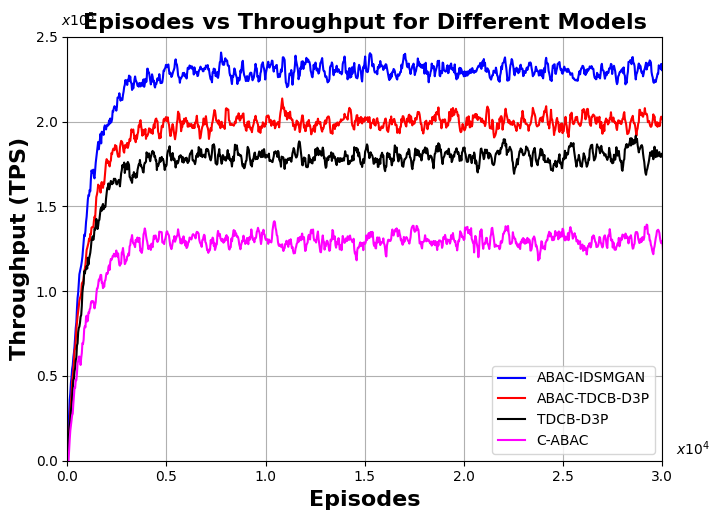

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Simple moving average function to smooth the data
def smooth_data(data, window_size=5):  # Reduced window size for less smoothing
    return np.convolve(data, np.ones(window_size)/window_size, mode='same')

# Simulate data for the graph
episodes = np.linspace(0, 3.05e4, 1000)  # Episodes range

# Reduced noise to avoid large spikes but allow some variation
throughput_ABACIDSMGAN = 2.3e5 * (1 - np.exp(-0.001 * episodes)) + np.random.normal(0, 8e3, size=episodes.shape)
throughput_ABACTDCBD3P = 2.0e5 * (1 - np.exp(-0.001 * episodes)) + np.random.normal(0, 8e3, size=episodes.shape)
throughput_TDCBD3P = 1.8e5 * (1 - np.exp(-0.001 * episodes)) + np.random.normal(0, 8e3, size=episodes.shape)
throughput_C_ABAC = 1.3e5 * (1 - np.exp(-0.001 * episodes)) + np.random.normal(0, 8e3, size=episodes.shape)

# Smooth the data with reduced window size for less smoothness
throughput_ABACIDSMGAN = smooth_data(throughput_ABACIDSMGAN, window_size=5)
throughput_ABACTDCBD3P = smooth_data(throughput_ABACTDCBD3P, window_size=5)
throughput_TDCBD3P = smooth_data(throughput_TDCBD3P, window_size=5)

throughput_C_ABAC = smooth_data(throughput_C_ABAC, window_size=5)

# Create the plot
plt.figure(figsize=(7, 5))

# Plot each scheme
plt.plot(episodes, throughput_ABACIDSMGAN, label="ABAC-IDSMGAN", color='blue')
plt.plot(episodes, throughput_ABACTDCBD3P, label="ABAC-TDCB-D3P", color='red')
plt.plot(episodes, throughput_TDCBD3P, label="TDCB-D3P", color='black')
plt.plot(episodes, throughput_C_ABAC, label="C-ABAC", color='magenta')

# Set axis labels and title
plt.xlabel("Episodes", fontsize=16, fontname='Times New Roman', fontweight='bold')
plt.ylabel("Throughput (TPS)", fontsize=16, fontname='Times New Roman', fontweight='bold')
plt.title("Episodes vs Throughput for Different Models", fontsize=16, fontname='Times New Roman', fontweight='bold')

# Set axis limits to ensure the graph starts at (0, 0)
plt.xlim(0, np.max(3e4))
plt.ylim(0, 2.5e5)  # Adjusted to better reflect the throughput values in the graph

# Add legend
plt.legend(loc="best")

# Set y-axis labels to display values in 10^5 with 'x10^5' notation
plt.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
plt.ticklabel_format(axis='x', style='sci', scilimits=(0, 0))
plt.gca().yaxis.get_offset_text().set_visible(False)  # Hide the default '1e5' text
plt.gca().xaxis.get_offset_text().set_visible(False)  # Hide the default '1e5' text

# Customize the offset text to 'x10^5'
plt.gca().annotate('$ x10^5$', xy=(0, 1), xytext=(20, 6),
                   xycoords='axes fraction', textcoords='offset points',
                   fontsize=10, ha='right', va='bottom')
plt.gca().annotate('$ x10^4$', xy=(1, 0), xytext=(10,2),
                   xycoords='axes fraction', textcoords='offset points',
                   fontsize=10, ha='left', va='bottom')

# Remove additional padding and ensure the graph is tight at the origin
plt.tight_layout(pad=0)  # This reduces padding around the plot

# Display the plot
plt.grid(True)
plt.show()


In [ ]:
class BlockchainComputingCosts:
    def __init__(self, num_nodes, signature_verification_cost=0.32, mac_verification_cost=0.3):
        """
        num_nodes: Number of nodes in the network.
        signature_verification_cost: Computational cost (GHz) for signature verification per transaction.
        mac_verification_cost: Computational cost (GHz) for MAC verification per transaction.
        """
        self.num_nodes = num_nodes
        self.signature_verification_cost = signature_verification_cost  # in GHz
        self.mac_verification_cost = mac_verification_cost  # in GHz

    def compute_costs(self):
        """
        Computes total computing costs for transaction validation.
        """
        total_cost_per_tx = self.signature_verification_cost + self.mac_verification_cost
        total_network_cost = self.num_nodes * total_cost_per_tx
        avg_cost_per_node = total_network_cost / self.num_nodes

        return {
            "num_nodes": self.num_nodes,
            "total_network_cost": total_network_cost,
            "avg_cost_per_node": round(avg_cost_per_node, 2)
        }

# Iterate over nodes from 100 to 500 and calculate computing costs
if __name__ == "__main__":
    for num_nodes in range(100, 501, 100):  # Iterate from 100 to 500 in steps of 100
        computing_costs = BlockchainComputingCosts(num_nodes=num_nodes)
        costs = computing_costs.compute_costs()

        print(f"Nodes: {costs['num_nodes']} | Total Computing Cost: {costs['total_network_cost']} GHz | Average Cost Per Node: {costs['avg_cost_per_node']} GHz")


Nodes: 100 | Total Computing Cost: 62.0 GHz | Average Cost Per Node: 0.62 GHz
Nodes: 200 | Total Computing Cost: 124.0 GHz | Average Cost Per Node: 0.62 GHz
Nodes: 300 | Total Computing Cost: 186.0 GHz | Average Cost Per Node: 0.62 GHz
Nodes: 400 | Total Computing Cost: 248.0 GHz | Average Cost Per Node: 0.62 GHz
Nodes: 500 | Total Computing Cost: 310.0 GHz | Average Cost Per Node: 0.62 GHz


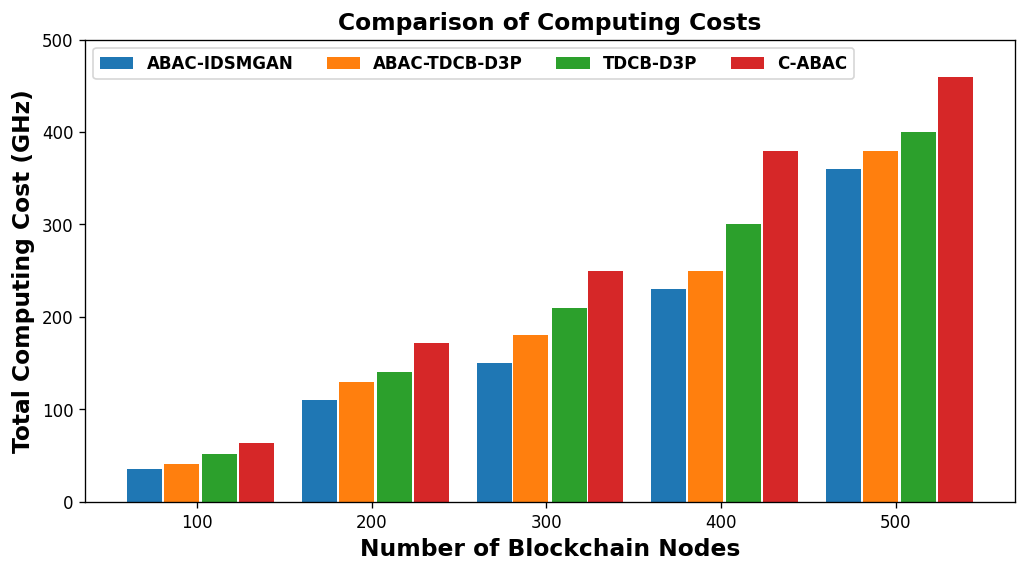

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Data
x = [100, 200, 300, 400, 500]
y1 = [64, 172, 250, 380, 460]
y2 = [52, 140, 210, 300, 400]
y3 = [41, 130, 180, 250, 380]
y4 = [35, 110, 150, 230, 360]

X_a = np.arange(len(x))

# Custom colors
#color1 = '#1f7777'  # ABAC-IDSMGAN
#color2 = '#ff7fff'  # ABAC-TDCB-D3P
#color3 = '#2caccc'  # TDCB-D3P
#color4 = '#d32567'  # C-ABAC

plt.figure(figsize=(10,5))
plt.bar(X_a - 0.1, y4, 0.2, label='ABAC-IDSMGAN')
plt.bar(X_a + 0.11, y3, 0.2, label='ABAC-TDCB-D3P')
plt.bar(X_a + 0.33, y2, 0.2, label='TDCB-D3P')
plt.bar(X_a + 0.54, y1, 0.2, label='C-ABAC')

plt.xlabel('Number of Blockchain Nodes', fontsize=14, fontweight='bold')
plt.ylabel('Total Computing Cost (GHz)', fontsize=14, fontweight='bold')
plt.title('Comparison of Computing Costs', fontsize=14, fontweight='bold')

plt.xticks(X_a + 0.2, ['100', '200', '300', '400', '500'])
plt.legend(fontsize='large', loc='upper left', prop={'weight': 'bold'}, ncol=4)
plt.ylim([0, 500])

fig = plt.gcf()
fig.set_dpi(120)

plt.show()


In [ ]:
import numpy as np

class BlockchainTPS:
    def __init__(self, block_size=5 * 1024 * 1024, avg_tx_size=200, block_time=0.06):
        self.block_size = block_size
        self.avg_tx_size = avg_tx_size
        self.block_time = block_time

    def calculate_tps(self, num_nodes):
        # Introduce node-based penalty to TPS
        node_penalty = 1 + (num_nodes / 1000)  # Higher nodes reduce TPS
        transactions_per_block = self.block_size / self.avg_tx_size
        tps = transactions_per_block / (self.block_time * node_penalty)
        return round(tps, 2)

class ConsensusSuccessProbability:
    def __init__(self, num_nodes, honest_nodes_ratio=0.99):
        self.num_nodes = num_nodes
        self.honest_nodes = int(num_nodes * honest_nodes_ratio)

    def compute_csp(self):
        honest_prob = self.honest_nodes / self.num_nodes
        if self.num_nodes > 1:
            csp = honest_prob ** np.log2(self.num_nodes)  # Dynamic CSP based on nodes
        else:
            csp = honest_prob
        return round(csp, 4)

class BlockchainComputingCosts:
    def __init__(self, num_nodes, signature_verification_cost=2, mac_verification_cost=1):
        self.num_nodes = num_nodes
        self.signature_verification_cost = signature_verification_cost
        self.mac_verification_cost = mac_verification_cost

    def compute_costs(self):
        total_cost_per_tx = self.signature_verification_cost + self.mac_verification_cost
        total_network_cost_mhz = self.num_nodes * total_cost_per_tx
        total_network_cost_ghz = total_network_cost_mhz / 10  # Convert MHz to GHz
        avg_cost_per_node_ghz = total_network_cost_ghz / self.num_nodes

        return {
            "num_nodes": self.num_nodes,
            "total_network_cost": round(total_network_cost_ghz, 4),
            "avg_cost_per_node": round(avg_cost_per_node_ghz, 4)
        }

if __name__ == "__main__":
    node_list = [100, 200, 300, 400, 500]  # Iterate over these node counts

    for num_nodes in node_list:
        print(f"\n--- Blockchain Performance for {num_nodes} Nodes ---")

        # TPS Calculation (varies with nodes)
        tps_calculator = BlockchainTPS()
        tps_value = tps_calculator.calculate_tps(num_nodes)
        print(f"Transactions Per Second (TPS): {tps_value}")

        # CSP Calculation (varies with nodes)
        csp_calculator = ConsensusSuccessProbability(num_nodes)
        csp_value = csp_calculator.compute_csp()
        print(f"Consensus Success Probability (CSP): {csp_value}")

        # Computing Cost Calculation
        computing_costs = BlockchainComputingCosts(num_nodes)
        costs = computing_costs.compute_costs()
        print(f"Total Computing Cost: {costs['total_network_cost']} GHz")
        #print(f"Average Cost Per Node: {costs['avg_cost_per_node']} GHz")



--- Blockchain Performance for 100 Nodes ---
Transactions Per Second (TPS): 397187.88
Consensus Success Probability (CSP): 0.9354
Total Computing Cost: 30.0 GHz

--- Blockchain Performance for 200 Nodes ---
Transactions Per Second (TPS): 364088.89
Consensus Success Probability (CSP): 0.9261
Total Computing Cost: 60.0 GHz

--- Blockchain Performance for 300 Nodes ---
Transactions Per Second (TPS): 336082.05
Consensus Success Probability (CSP): 0.9206
Total Computing Cost: 90.0 GHz

--- Blockchain Performance for 400 Nodes ---
Transactions Per Second (TPS): 312076.19
Consensus Success Probability (CSP): 0.9168
Total Computing Cost: 120.0 GHz

--- Blockchain Performance for 500 Nodes ---
Transactions Per Second (TPS): 291271.11
Consensus Success Probability (CSP): 0.9138
Total Computing Cost: 150.0 GHz


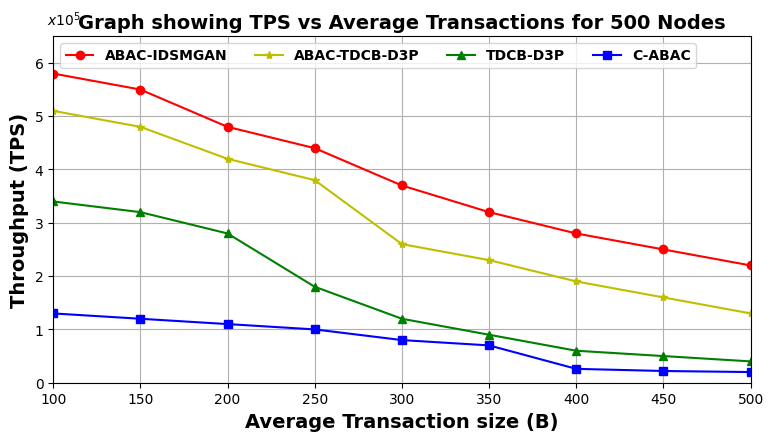

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data for specific x values
x = np.array([100, 150, 200, 250, 300, 350, 400, 450, 500])

# Corresponding y values for the given x values (TPS values for each method)
y1 = np.array([5.8e5, 5.5e5, 4.8e5, 4.4e5, 3.7e5, 3.2e5, 2.8e5, 2.5e5, 2.2e5])  # ABAC-IDSMGAN
y2 = np.array([5.1e5, 4.8e5, 4.2e5, 3.8e5, 2.6e5, 2.3e5, 1.9e5, 1.6e5, 1.3e5])  # ABAC-TDCB-D3P
y3 = np.array([3.4e5, 3.2e5, 2.8e5, 1.8e5, 1.2e5, 0.9e5, 0.6e5, 0.5e5, 0.4e5])  # TDCB-D3P
y4 = np.array([1.3e5, 1.2e5, 1.1e5, 1.0e5, 0.8e5, 0.7e5, 2.6e4, 2.2e4, 2.0e4])  # C-ABAC

# Plotting the graph
plt.figure(figsize=(9, 4.5))
plt.plot(x, y1, 'ro-', label='ABAC-IDSMGAN')
plt.plot(x, y2, 'y*-', label='ABAC-TDCB-D3P')
plt.plot(x, y3, 'g^-', label='TDCB-D3P')
plt.plot(x, y4, 'bs-', label='C-ABAC')

# Adding labels and title
plt.xlabel('Average Transaction size (B)', fontsize='14', fontname='Times New Roman', fontweight='bold')
plt.ylabel('Throughput (TPS)', fontsize='14', fontname='Times New Roman', fontweight='bold')
plt.title('Graph showing TPS vs Average Transactions for 500 Nodes', fontsize='14', fontname='Times New Roman', fontweight='bold')
plt.ylim([0e5, 6.5e5])  # Set y-axis limit to match the data range
plt.xlim([100, 500])  # Set x-axis limit to match x values

# Adding legend to specify each line
plt.legend(fontsize='small', loc='upper left', prop={'weight': 'bold'}, ncol=4)

# Set y-axis labels to display values in 10^5 with 'x10^5' notation
plt.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
plt.gca().yaxis.get_offset_text().set_visible(False)  # Hide the default '1e5' text

# Customize the offset text to 'x10^5'
plt.gca().annotate('$ x10^5$', xy=(0, 1), xytext=(20, 6),
                   xycoords='axes fraction', textcoords='offset points',
                   fontsize=10, ha='right', va='bottom')

# Displaying the plot
plt.grid(True)
plt.show()


In [ ]:
import numpy as np

class TrustBasedConsensus:
    def __init__(self, num_nodes):
        self.num_nodes = num_nodes
        self.trust_values = np.random.uniform(0.5, 1.0, num_nodes)

    def update_trust(self, node_index, feedback):
        if feedback == "good":
            self.trust_values[node_index] = min(self.trust_values[node_index] + 0.05, 1.0)
        else:
            self.trust_values[node_index] = max(self.trust_values[node_index] - 0.1, 0.0)

    def select_delegates(self, num_delegates):
        sorted_nodes = np.argsort(self.trust_values)[::-1]
        return sorted_nodes[:num_delegates]

consensus = TrustBasedConsensus(num_nodes=100)
delegates = consensus.select_delegates(num_delegates=10)
print("Selected Delegates:", delegates)


Selected Delegates: [64 85 21 63 56 36 86 57 65 95]


In [ ]:
import numpy as np

class BlockchainTPS:
    def __init__(self, block_size=5 * 1024 * 1024, avg_tx_size=200, block_time=0.06):
        self.block_size = block_size
        self.avg_tx_size = avg_tx_size
        self.block_time = block_time

    def calculate_tps(self, num_nodes):
        # Introduce node-based penalty to TPS
        node_penalty = 1 + (num_nodes / 1000)  # Higher nodes reduce TPS
        transactions_per_block = self.block_size / self.avg_tx_size
        tps = transactions_per_block / (self.block_time * node_penalty)
        return round(tps, 2)

class ConsensusSuccessProbability:
    def __init__(self, num_nodes, honest_nodes_ratio=0.99):
        self.num_nodes = num_nodes
        self.honest_nodes = int(num_nodes * honest_nodes_ratio)

    def compute_csp(self):
        honest_prob = self.honest_nodes / self.num_nodes
        if self.num_nodes > 1:
            csp = honest_prob ** np.log2(self.num_nodes)  # Dynamic CSP based on nodes
        else:
            csp = honest_prob
        return round(csp, 4)

class BlockchainComputingCosts:
    def __init__(self, num_nodes, signature_verification_cost=2, mac_verification_cost=1):
        self.num_nodes = num_nodes
        self.signature_verification_cost = signature_verification_cost
        self.mac_verification_cost = mac_verification_cost

    def compute_costs(self):
        total_cost_per_tx = self.signature_verification_cost + self.mac_verification_cost
        total_network_cost_mhz = self.num_nodes * total_cost_per_tx
        total_network_cost_ghz = total_network_cost_mhz / 10  # Convert MHz to GHz
        avg_cost_per_node_ghz = total_network_cost_ghz / self.num_nodes

        return {
            "num_nodes": self.num_nodes,
            "total_network_cost": round(total_network_cost_ghz, 4),
            "avg_cost_per_node": round(avg_cost_per_node_ghz, 4)
        }

if __name__ == "__main__":
    node_list = [100, 200, 300, 400, 500]  # Iterate over these node counts

    for num_nodes in node_list:
        print(f"\n--- Blockchain Performance for {num_nodes} Nodes ---")

        # TPS Calculation (varies with nodes)
        tps_calculator = BlockchainTPS()
        tps_value = tps_calculator.calculate_tps(num_nodes)
        print(f"Transactions Per Second (TPS): {tps_value}")

        # CSP Calculation (varies with nodes)
        csp_calculator = ConsensusSuccessProbability(num_nodes)
        csp_value = csp_calculator.compute_csp()
        print(f"Consensus Success Probability (CSP): {csp_value}")

        # Computing Cost Calculation
        computing_costs = BlockchainComputingCosts(num_nodes)
        costs = computing_costs.compute_costs()
        print(f"Total Computing Cost: {costs['total_network_cost']} GHz")
        #print(f"Average Cost Per Node: {costs['avg_cost_per_node']} GHz")



--- Blockchain Performance for 100 Nodes ---
Transactions Per Second (TPS): 397187.88
Consensus Success Probability (CSP): 0.9354
Total Computing Cost: 30.0 GHz

--- Blockchain Performance for 200 Nodes ---
Transactions Per Second (TPS): 364088.89
Consensus Success Probability (CSP): 0.9261
Total Computing Cost: 60.0 GHz

--- Blockchain Performance for 300 Nodes ---
Transactions Per Second (TPS): 336082.05
Consensus Success Probability (CSP): 0.9206
Total Computing Cost: 90.0 GHz

--- Blockchain Performance for 400 Nodes ---
Transactions Per Second (TPS): 312076.19
Consensus Success Probability (CSP): 0.9168
Total Computing Cost: 120.0 GHz

--- Blockchain Performance for 500 Nodes ---
Transactions Per Second (TPS): 291271.11
Consensus Success Probability (CSP): 0.9138
Total Computing Cost: 150.0 GHz


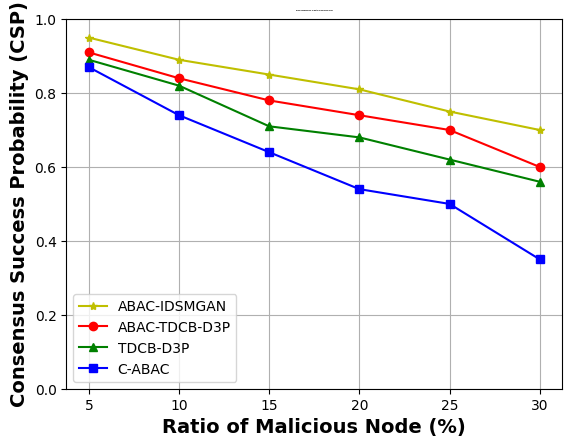

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data
x = np.array([5, 10, 15, 20, 25, 30])
y4 = np.array([0.87, 0.74, 0.64, 0.54, 0.5, 0.35])
y3 = np.array([0.89, 0.82, 0.71, 0.68, 0.62, 0.56])
y2 = np.array([0.91, 0.84, 0.78, 0.74, 0.7, 0.6])
y1 = np.array([0.95, 0.89, 0.85, 0.81, 0.75, 0.70])  # Added an extra value to match the length of x

# Plotting the graph
plt.plot(x, y1, 'y*-', label='ABAC-IDSMGAN')
plt.plot(x, y2, 'ro-', label='ABAC-TDCB-D3P')
plt.plot(x, y3, 'g^-', label='TDCB-D3P')
plt.plot(x, y4, 'bs-', label='C-ABAC')

# Adding labels and title with bold font
plt.xlabel('Ratio of Malicious Node (%)', fontweight='bold', fontsize='14',fontname="Times New Roman")
plt.ylabel('Consensus Success Probability (CSP)', fontweight='bold',fontsize='14',fontname="Times New Roman")
plt.title('Graph showing CSP vs Ratio of Malicious Node', fontweight='bold',fontsize='1',fontname="Times New Roman")
plt.ylim([0, 1])
# Adding legend to specify each line
plt.legend()

# Displaying the plot
plt.grid(True)
plt.show()


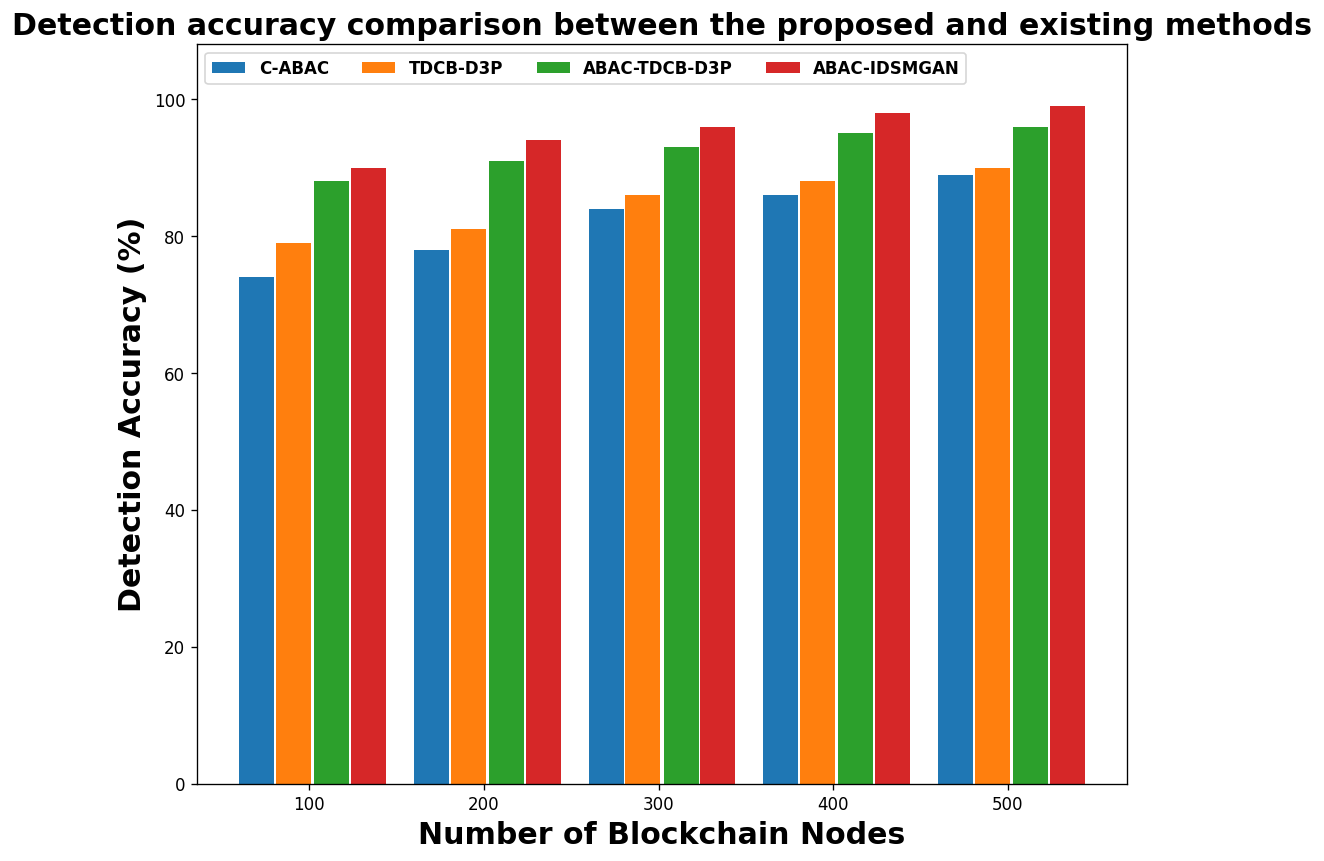

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Data
x = [100, 200, 300, 400, 500]
y1 = [74, 78, 84, 86, 89]
y2 = [79, 81, 86, 88, 90]
y3 = [88, 91, 93, 95, 96]
y4 = [90, 94, 96, 98, 99]

X_a = np.arange(len(x))

# Custom colors
#color1 = '#1c4565'  # ABAC-IDSMGAN
#color2 = '#dec321'  # ABAC-TDCB-D3P
#color3 = '#909021'  # TDCB-D3P
#color4 = '#aec789'  # C-ABAC

plt.figure(figsize=(10, 8))
plt.bar(X_a - 0.1, y1, 0.2, label='C-ABAC')
plt.bar(X_a + 0.11, y2, 0.2, label='TDCB-D3P')
plt.bar(X_a + 0.33, y3, 0.2, label='ABAC-TDCB-D3P')
plt.bar(X_a + 0.54, y4, 0.2, label='ABAC-IDSMGAN')

plt.xlabel('Number of Blockchain Nodes', fontsize=18, fontweight='bold', fontname="Times New Roman")
plt.ylabel('Detection Accuracy (%)', fontsize=18, fontweight='bold', fontname="Times New Roman")
plt.title('Detection accuracy comparison between the proposed and existing methods', fontsize=18, fontweight='bold',fontname="Times New Roman")

plt.xticks(X_a + 0.2, ['100', '200', '300', '400', '500'])
plt.legend(fontsize='small', loc='upper left', prop={'weight': 'bold'}, ncol=4)
plt.ylim([0, 108])


fig = plt.gcf()
fig.set_dpi(120)

plt.show()
